# 统计目录下照片的多种信息如焦距、光圈、快门速度等，提供一些趣味以及尽头购买的参考 | Count the focal length, aperture, shutter speed, etc. of the photos in the directory, provide some fun and purchase reference

## 导入需要使用的包，指定文件路径和图片类型 | Import the necessary packages and specify the file path and image type to be used

In [1]:
import pandas as pd  # pip install pyarrow may be suggested
import matplotlib.pyplot as plt
import os
from PIL import Image  # https://pillow.readthedocs.io/en/stable/releasenotes/3.1.0.html
import sys

file_path = "K:\BaiduSyncdisk\Photos"
file_type_a = ".jpg", ".jpeg", ".png"
file_type_A = tuple(map(str.upper, file_type_a))

if not os.path.exists(file_path):
    print("目录不存在")
    sys.exit()

print(file_type_a, file_type_A)

('.jpg', '.jpeg', '.png') ('.JPG', '.JPEG', '.PNG')


## 读取所有目录下的图片文件 | Read all image files in the directory

In [2]:
# define a list to store the image's file pathes, including the subfolders
jpg_path_list = []
# set
error_path_list = set()
TOTAL_SIZE = 0
for root, dirs, files in os.walk(file_path):
    for file in files:
        if file.endswith(file_type_A) or file.endswith(file_type_a):
            jpg_path_list.append(os.path.join(root, file))
# print the size of the list
TOTAL_SIZE = len(jpg_path_list)
print("The number of the image file is: ", TOTAL_SIZE)
print(jpg_path_list[0:5])

The number of the image file is:  15298
['K:\\BaiduSyncdisk\\Photos\\Avatar.png', 'K:\\BaiduSyncdisk\\Photos\\117_PANA\\P1170674.JPG', 'K:\\BaiduSyncdisk\\Photos\\117_PANA\\P1170675.JPG', 'K:\\BaiduSyncdisk\\Photos\\117_PANA\\P1170676.JPG', 'K:\\BaiduSyncdisk\\Photos\\117_PANA\\P1170677.JPG']


## 定义需要使用的方法 | Define the methods to be used
``` ref: https://exiv2.org/tags.html ```


In [3]:
def get_focal_length(image_path):
    """
    Get the focal length of the image.
    :param image_path: the path of the image
    :return: the focal length of the image
    """
    try:
        focal_length = Image.open(image_path)._getexif()[37386]
    except:
        error_path_list.add(image_path)
        PrintErrorImage(image_path)
        return

    return focal_length


def get_F_stop(image_path):
    """
    Get the F-stop of the image.
    :param image_path: the path of the image
    :return: the F-stop of the image
    """
    try:
        F_stop = Image.open(image_path)._getexif()[33437]
    except:
        error_path_list.add(image_path)
        PrintErrorImage(image_path)
        return
    return F_stop


def get_ISO(image_path):
    """
    Get the ISO of the image.
    :param image_path: the path of the image
    :return: the ISO of the image
    """
    try:
        ISO = Image.open(image_path)._getexif()[34855]
    except:
        error_path_list.add(image_path)
        PrintErrorImage(image_path)
        return
    return ISO


def get_shutter_speed(image_path):
    """
    Get the shutter speed of the image.
    :param image_path: the path of the image
    :return: the shutter speed of the image
    """
    try:
        shutter_speed = Image.open(image_path)._getexif()[33434]
    except:
        error_path_list.add(image_path)
        PrintErrorImage(image_path)
        return
    return shutter_speed


def get_metadata(image_path):
    """
    Fetches focal length, F-stop, ISO, and shutter speed of an image in one function call.
    """
    try:
        img = Image.open(image_path)
        exif_data = img._getexif()
        focal_length = exif_data.get(37386)
        F_stop = exif_data.get(33437)
        ISO = exif_data.get(34855)
        shutter_speed = exif_data.get(33434)
    except Exception as e:
        error_path_list.add(image_path)
        PrintErrorImage(image_path)
        return None, None, None, None
    return shutter_speed, ISO, focal_length, F_stop


def PrintErrorImage(image_path):
    print(
        "Error image: ",
        image_path,
        "may not have focal length, F-stop, ISO, or shutter speed",
    )


def print_progress(progressName, current, total):
    """
    PRINT THE PROGRESS OF THE PROCESS
    :param current: the current number of the process
    :param total: the total number of the process
    """
    progress = current / total
    sys.stdout.write(
        "\r"
        + progressName
        + " Progress: [{0:50s}] {1:.1f}%".format(
            "=" * int(progress * 50), progress * 100
        )
    )
    sys.stdout.flush()

## 读取图片信息并存储到pandas的DataFrame中|Read the image information and store it in the pandas DataFrame
速度可能较慢，待优化？ | May be slow, to be optimized?

In [ ]:
# shutter_speed_list = []
# ISO_list = []
# focal_length_list = []
# F_stop_list = []
# for jpg_path in jpg_path_list:
#     shutter_speed = get_shutter_speed(jpg_path)
#     ISO = get_ISO(jpg_path)
#     focal_length = get_focal_length(jpg_path)
#     F_stop = get_F_stop(jpg_path)

#     shutter_speed_list.append(shutter_speed)
#     ISO_list.append(ISO)
#     focal_length_list.append(focal_length)
#     F_stop_list.append(F_stop)
#     print_progress("Reading Images", len(shutter_speed_list), len(jpg_path_list))

Alittle bit faster version by using ThreadPoolExecutor:

In [5]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import sys

# 创建列表以存储元数据
shutter_speed_list = []
ISO_list = []
focal_length_list = []
F_stop_list = []

# 使用并行执行并添加进度显示
total_images = len(jpg_path_list)
completed_images = 0

with ThreadPoolExecutor() as executor:
    # 提交任务并获得future对象
    futures = {
        executor.submit(get_metadata, jpg_path): jpg_path for jpg_path in jpg_path_list
    }

    # 使用 as_completed 逐个处理已完成的任务
    for future in as_completed(futures):
        result = future.result()  # 获取结果
        shutter_speed, ISO, focal_length, F_stop = result

        # 将结果添加到对应的列表中
        shutter_speed_list.append(shutter_speed)
        ISO_list.append(ISO)
        focal_length_list.append(focal_length)
        F_stop_list.append(F_stop)

        # 更新已完成数量和百分比
        completed_images += 1
        progress = (completed_images / total_images) * 100
        sys.stdout.write(
            f"\rProgress: [{completed_images}/{total_images}] {progress:.2f}%"
        )
        sys.stdout.flush()

print("\n数据读取完成！")

Progress: [11/15298] 0.07%Error image:  K:\BaiduSyncdisk\Photos\Avatar.png may not have focal length, F-stop, ISO, or shutter speed
Progress: [7098/15298] 46.40%Error image:  K:\BaiduSyncdisk\Photos\川藏自驾\微信图片_20240805214418.jpg may not have focal length, F-stop, ISO, or shutter speed
Progress: [7792/15298] 50.93%Error image:  K:\BaiduSyncdisk\Photos\川藏自驾\好看的伙伴\伙伴们2.jpg may not have focal length, F-stop, ISO, or shutter speed
Error image:  K:\BaiduSyncdisk\Photos\川藏自驾\好看的伙伴\伙伴们3.jpg may not have focal length, F-stop, ISO, or shutter speed
Error image:  K:\BaiduSyncdisk\Photos\川藏自驾\好看的伙伴\伙伴们1.jpg may not have focal length, F-stop, ISO, or shutter speed
Progress: [7806/15298] 51.03%

C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (92812500 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\admin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (161250000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Progress: [8843/15298] 57.80%Error image:  K:\BaiduSyncdisk\Photos\川藏自驾\好看的伙伴\微信图片_20240806210645.png may not have focal length, F-stop, ISO, or shutter speed
Progress: [12056/15298] 78.81%Error image: Error image:  K:\BaiduSyncdisk\Photos\校园风景\._IMG_2764.JPG may not have focal length, F-stop, ISO, or shutter speed
 K:\BaiduSyncdisk\Photos\校园风景\._IMG_2762.JPG may not have focal length, F-stop, ISO, or shutter speed
Progress: [15029/15298] 98.24%Error image:  K:\BaiduSyncdisk\Photos\水印\批处理20241017224751\shot_20240928_160402.png may not have focal length, F-stop, ISO, or shutter speed
Progress: [15030/15298] 98.25%Error image:  K:\BaiduSyncdisk\Photos\水印\批处理20241017224751\shot_20240921_160110.png may not have focal length, F-stop, ISO, or shutter speed
Progress: [15031/15298] 98.25%Error image:  K:\BaiduSyncdisk\Photos\水印\批处理20241017224751\shot_20240921_161749.png may not have focal length, F-stop, ISO, or shutter speed
Progress: [15032/15298] 98.26%Error image:  K:\BaiduSyncdisk\Photos\

In [6]:
data = {
    "shutter_speed(s)": shutter_speed_list,
    "ISO": ISO_list,
    "focal_length(mm)": focal_length_list,
    "F_stop(/f)": F_stop_list,
}
images_df = pd.DataFrame(data, index=jpg_path_list)
print("\n The error image list is: ", error_path_list.__str__().replace("//", "/"))
images_df


 The error image list is:  {'K:\\BaiduSyncdisk\\Photos\\水印\\批处理20241017224751\\shot_20240928_155227.png', 'K:\\BaiduSyncdisk\\Photos\\水印\\批处理20241017224751\\shot_20240924_150121.png', 'K:\\BaiduSyncdisk\\Photos\\水印\\批处理20241017224751\\shot_20240921_161913.png', 'K:\\BaiduSyncdisk\\Photos\\水印\\批处理20241017224751\\shot_20241011_144513.png', 'K:\\BaiduSyncdisk\\Photos\\水印\\批处理20241017224751\\shot_20240925_144157.png', 'K:\\BaiduSyncdisk\\Photos\\水印\\批处理20241017224751\\shot_20241013_035043.png', 'K:\\BaiduSyncdisk\\Photos\\水印\\批处理20241017224751\\shot_20240928_162516.png', 'K:\\BaiduSyncdisk\\Photos\\水印\\批处理20241017224751\\shot_20241014_132742.png', 'K:\\BaiduSyncdisk\\Photos\\水印\\批处理20241017224751\\shot_20240928_160918.png', 'K:\\BaiduSyncdisk\\Photos\\水印\\批处理20241017224751\\shot_20241015_152422.png', 'K:\\BaiduSyncdisk\\Photos\\水印\\批处理20241017224751\\shot_20241013_035128.png', 'K:\\BaiduSyncdisk\\Photos\\水印\\批处理20241017224751\\shot_20240928_160402.png', 'K:\\BaiduSyncdisk\\Photos\\水印\\批处理

,shutter_speed(s),ISO,focal_length(mm),F_stop(/f)
K:\BaiduSyncdisk\Photos\Avatar.png,0.00625,100.0,6.3,4.0
K:\BaiduSyncdisk\Photos\117_PANA\P1170674.JPG,0.008,100.0,7.5,4.0
K:\BaiduSyncdisk\Photos\117_PANA\P1170675.JPG,0.0025,100.0,6.3,6.3
K:\BaiduSyncdisk\Photos\117_PANA\P1170676.JPG,0.025,100.0,7.5,3.2
K:\BaiduSyncdisk\Photos\117_PANA\P1170677.JPG,0.07692307692307693,200.0,6.3,2.8
...,...,...,...,...
K:\BaiduSyncdisk\Photos\漫展\IMG_3182.JPG,None,NaN,None,None
K:\BaiduSyncdisk\Photos\漫展\IMG_3184.JPG,None,NaN,None,None
K:\BaiduSyncdisk\Photos\漫展\IMG_3185.JPG,None,NaN,None,None
K:\BaiduSyncdisk\Photos\漫展\IMG_3189.JPG,None,NaN,None,None


## 搜索目录内图片名称来确保图片是否被正确读取 | Search the directory for image names to ensure that the images are read correctly


In [7]:
target_image_path = "IMG_1339.JPG"
for index in images_df.index:
    if index.endswith(target_image_path):
        print(target_image_path + " was found at index: ", index)

IMG_1339.JPG was found at index:  K:\BaiduSyncdisk\Photos\2023-9-BackHome\IMG_1339.JPG
IMG_1339.JPG was found at index:  K:\BaiduSyncdisk\Photos\校园风景\IMG_1339.JPG


## 分析图片的焦距（如果你有一个变焦镜头的话） | Analyze the focal length of the image (if you have a zoom lens)

In [8]:
# 定义一个焦段字典，以焦段为键，以数量为值|define a dictionary to store the focal length as the key and the number as the value
focal_length_dict = {
    "8-15 ": 0,
    "16-24": 0,
    "24-35": 0,
    "35-50": 0,
    "50-70": 0,
    "70-105": 0,
    "105-135": 0,
    "135-200": 0,
    "200-300": 0,
    "300-400": 0,
    "400-600": 0,
    "600-800": 0,
    "800-1200": 0,
    "1200-1600": 0,
    "1600-2000": 0,
}


def count_focal_length(df, dict):
    progress = 0
    invalid_count = 0
    # get all
    for index, row in df.iterrows():
        focal_length = row["focal_length(mm)"]
        if focal_length is None:
            invalid_count += 1
            print("Invalid focal length", index)
            continue
        if focal_length < 15:
            dict["8-15 "] += 1
        elif focal_length < 25:
            dict["16-24"] += 1
        elif focal_length < 35:
            dict["24-35"] += 1
        elif focal_length < 50:
            dict["35-50"] += 1
        elif focal_length < 70:
            dict["50-70"] += 1
        elif focal_length < 105:
            dict["70-105"] += 1
        elif focal_length < 135:
            dict["105-135"] += 1
        elif focal_length < 200:
            dict["135-200"] += 1
        elif focal_length < 300:
            dict["200-300"] += 1
        elif focal_length < 400:
            dict["300-400"] += 1
        elif focal_length < 600:
            dict["400-600"] += 1
        elif focal_length < 800:
            dict["600-800"] += 1
        elif focal_length < 1200:
            dict["800-1200"] += 1
        elif focal_length < 1600:
            dict["1200-1600"] += 1
        elif focal_length < 2000:
            dict["1600-2000"] += 1
        progress += 1
        print_progress("Counting Focal Length", progress, len(df))
    return invalid_count


invalid_count = count_focal_length(images_df, focal_length_dict)
print(" Invalid focal length count: ", invalid_count)
focal_length_dict

Counting Focal Length Progress: [                                                  ] 1.6%Invalid focal length K:\BaiduSyncdisk\Photos\117_PANA\P1170973.JPG
Counting Focal Length Progress: [=====                                             ] 10.0%Invalid focal length K:\BaiduSyncdisk\Photos\2024-10 回家\2024-10-4\IMG_0017.JPG
Counting Focal Length Progress: [=====                                             ] 11.3%Invalid focal length K:\BaiduSyncdisk\Photos\2024-10 回家\2024-10-4\IMG_9934.JPG
Invalid focal length K:\BaiduSyncdisk\Photos\2024-10 回家\2024-10-4\IMG_9936.JPG
Counting Focal Length Progress: [=====                                             ] 11.7%Invalid focal length K:\BaiduSyncdisk\Photos\2024-10 回家\2024-10-4\无人机\IMG_9884.JPG
Counting Focal Length Progress: [======                                            ] 12.1%Invalid focal length K:\BaiduSyncdisk\Photos\2024-10 回家\2024-10-5\IMG_0080.JPG
Counting Focal Length Progress: [==============                                    ] 

{'8-15 ': 989,
 '16-24': 2156,
 '24-35': 627,
 '35-50': 1600,
 '50-70': 1897,
 '70-105': 3689,
 '105-135': 1064,
 '135-200': 1997,
 '200-300': 402,
 '300-400': 210,
 '400-600': 496,
 '600-800': 0,
 '800-1200': 0,
 '1200-1600': 0,
 '1600-2000': 0}

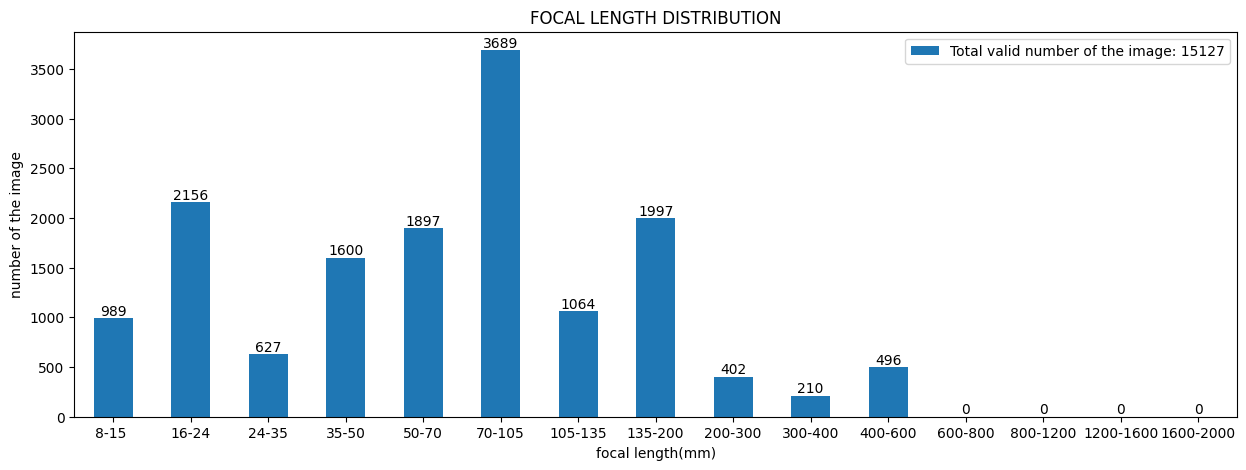

In [9]:
# 以柱状图的形式展示焦段字典，plot标题为照片总数，y轴为焦段，x轴为照片数量，并在每个柱状图上显示照片数量
plt.figure(figsize=(15, 5))
focal_length_series = pd.Series(focal_length_dict)
focal_length_series.plot(kind="bar", title=str.upper("focal length distribution"))
for x, y in enumerate(focal_length_series):
    plt.text(x, y, "%s" % y, ha="center", va="bottom")
plt.legend(["Total valid number of the image: " + str(TOTAL_SIZE - invalid_count)])
plt.xticks(rotation=0)
plt.xlabel("focal length(mm)")
plt.ylabel("number of the image")
plt.show(block=False)

以上统计结果可以一定程度上反映出自己喜欢的焦段（前提是你有一个变焦镜头），可以帮助自己更好的选择镜头。

### 汇合常用焦段

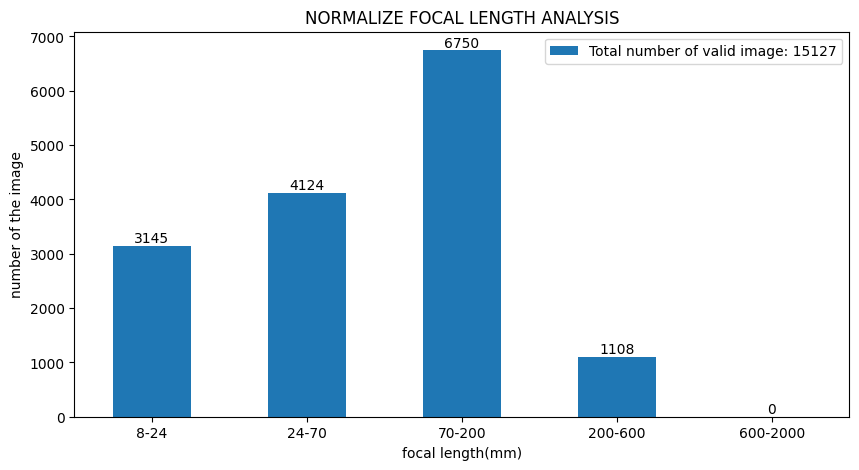

In [10]:
# 自定义一个常用焦距区间dict，以焦距区间为键，以数量为值
focal_length_dict_Normal = {
    "8-24": 0,
    "24-70": 0,
    "70-200": 0,
    "200-600": 0,
    "600-2000": 0,
}
# 遍历先前的焦段字典，将焦段数量累加到常用焦距区间字典中
for key, value in focal_length_dict.items():
    if key == "8-15 " or key == "16-24":
        focal_length_dict_Normal["8-24"] += value
    elif key == "24-35" or key == "35-50" or key == "50-70":
        focal_length_dict_Normal["24-70"] += value
    elif key == "70-105" or key == "105-135" or key == "135-200":
        focal_length_dict_Normal["70-200"] += value
    elif key == "200-300" or key == "300-400" or key == "400-600":
        focal_length_dict_Normal["200-600"] += value
    elif (
        key == "600-800"
        or key == "800-1200"
        or key == "1200-1600"
        or key == "1600-2000"
    ):
        focal_length_dict_Normal["600-2000"] += value
# 以柱状图的形式展示焦距区间字典，plot标题为照片总数，y轴为焦距区间，x轴为照片数量，并在每个柱状图上显示照片数量
plt.figure(figsize=(10, 5))

focal_length_series_custom = pd.Series(focal_length_dict_Normal)
focal_length_series_custom.plot(
    kind="bar", title=str.upper("Normalize focal length analysis")
)
for x, y in enumerate(focal_length_series_custom):
    plt.text(x, y, "%s" % y, ha="center", va="bottom")
plt.xticks(rotation=0)
plt.legend(["Total number of valid image: " + str(TOTAL_SIZE - invalid_count)])
plt.xlabel("focal length(mm)")
plt.ylabel("number of the image")
plt.show(block=False)

## 分析图片的光圈

In [11]:
# 统计光圈值，遍历images_df,获取每张图片的光圈值,如果光圈值不在字典中，则将其添加到字典中
F_stop_dict = {}


def count_F_stop(df, dict):
    progress = 0
    invalid_count = 0
    for index, row in df.iterrows():
        if row["F_stop(/f)"] is None:
            print("Invalid F-stop", index)
            invalid_count += 1
            continue
        F_stop = row["F_stop(/f)"]
        if F_stop not in dict:
            dict[F_stop] = 1
        else:
            dict[F_stop] += 1
        progress += 1
        print_progress("Counting F-stop", progress, len(df))
    return dict, invalid_count


invalid_count = count_F_stop(images_df, F_stop_dict)[1]
# 根据F_stop_dict 的键排序，以便于后续画图
F_stop_dict = dict(sorted(F_stop_dict.items()))

Counting F-stop Progress: [                                                  ] 1.6%Invalid F-stop K:\BaiduSyncdisk\Photos\117_PANA\P1170973.JPG
Counting F-stop Progress: [=====                                             ] 10.0%Invalid F-stop K:\BaiduSyncdisk\Photos\2024-10 回家\2024-10-4\IMG_0017.JPG
Counting F-stop Progress: [=====                                             ] 11.3%Invalid F-stop K:\BaiduSyncdisk\Photos\2024-10 回家\2024-10-4\IMG_9934.JPG
Invalid F-stop K:\BaiduSyncdisk\Photos\2024-10 回家\2024-10-4\IMG_9936.JPG
Counting F-stop Progress: [=====                                             ] 11.7%Invalid F-stop K:\BaiduSyncdisk\Photos\2024-10 回家\2024-10-4\无人机\IMG_9884.JPG
Counting F-stop Progress: [======                                            ] 12.1%Invalid F-stop K:\BaiduSyncdisk\Photos\2024-10 回家\2024-10-5\IMG_0080.JPG
Counting F-stop Progress: [==============                                    ] 28.8%Invalid F-stop K:\BaiduSyncdisk\Photos\3D打印\IMG_7478.JPG
Counting F

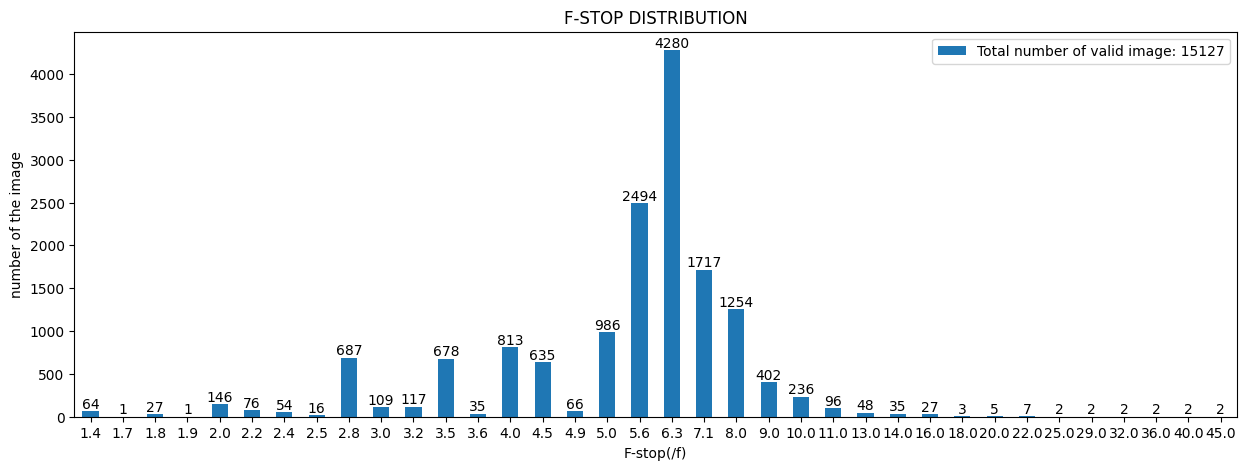

In [12]:
# 以柱状图的形式展示光圈值字典，plot标题为照片总数，y轴为光圈值，x轴为照片数量，并在每个柱状图上显示照片数量
plt.figure(figsize=(15, 5))
F_stop_series = pd.Series(F_stop_dict)
F_stop_series.plot(kind="bar", title=str.upper("F-stop distribution"))
for x, y in enumerate(F_stop_series):
    plt.text(x, y, "%s" % y, ha="center", va="bottom")
plt.xlabel("F-stop(/f)")
plt.ylabel("number of the image")
plt.legend(["Total number of valid image: " + str(TOTAL_SIZE - invalid_count)])
plt.xticks(rotation=0)
plt.show(block=False)

## 分析图片的快门速度？

In [13]:
# To be continued??

## 快门速度、光圈、焦距之间的关系？| Relationship between shutter speed, aperture, and focal length?

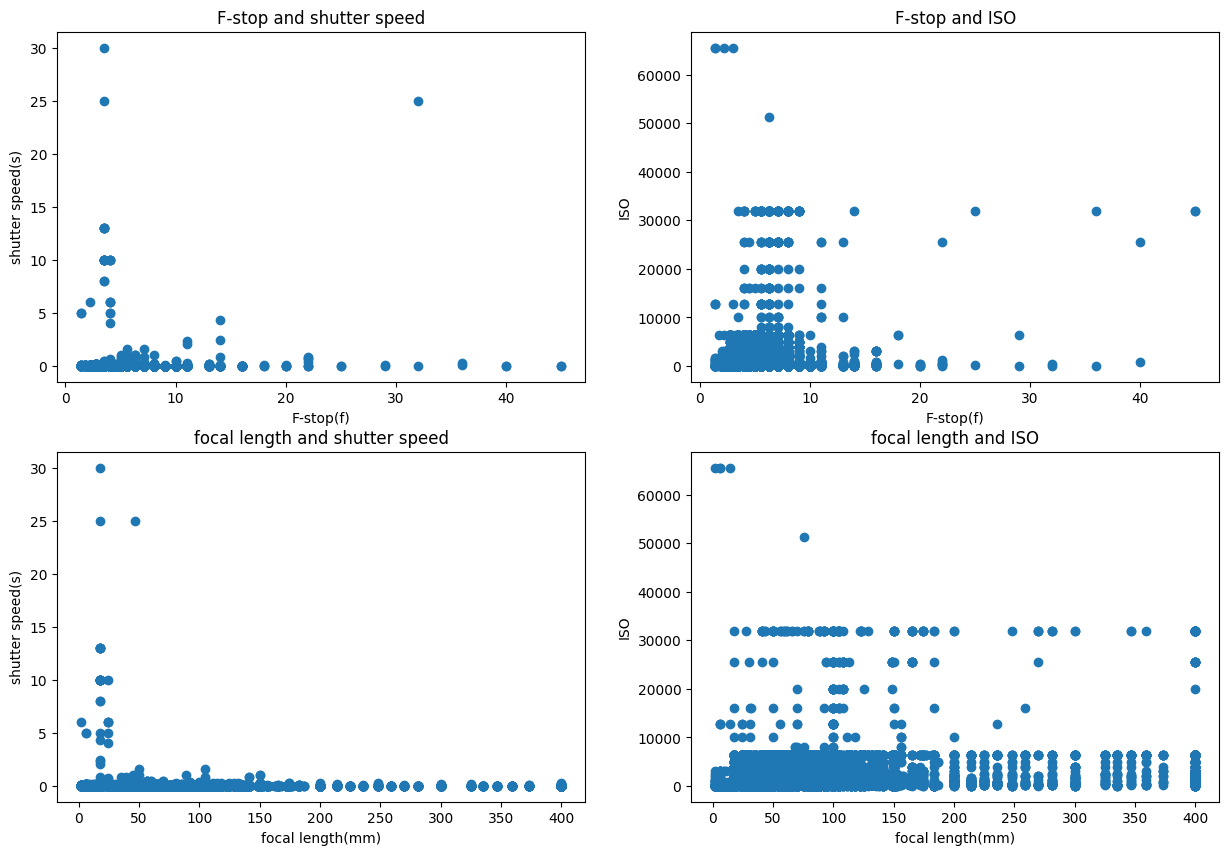

In [14]:
# 以光圈值为y轴，快门速度为x轴，绘制散点图; 以光圈值为x轴，ISO值为y轴，绘制散点图; 以焦距为x轴，快门速度为y轴，绘制散点图; 以焦距为x轴，ISO值为y轴，绘制散点图;
# draw the scatter plot of the relationship between F-stop and shutter speed, F-stop and ISO, focal length and shutter speed, focal length and ISO
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.scatter(F_stop_list, shutter_speed_list)
plt.title("F-stop and shutter speed")
plt.xlabel("F-stop(f)")
plt.ylabel("shutter speed(s)")

plt.subplot(2, 2, 2)
plt.scatter(F_stop_list, ISO_list)
plt.title("F-stop and ISO")
plt.xlabel("F-stop(f)")
plt.ylabel("ISO")
plt.subplot(2, 2, 3)
plt.scatter(focal_length_list, shutter_speed_list)
plt.title("focal length and shutter speed")
plt.xlabel("focal length(mm)")
plt.ylabel("shutter speed(s)")

plt.subplot(2, 2, 4)
plt.scatter(focal_length_list, ISO_list)
plt.title("focal length and ISO")
plt.xlabel("focal length(mm)")
plt.ylabel("ISO")
plt.show(block=False)

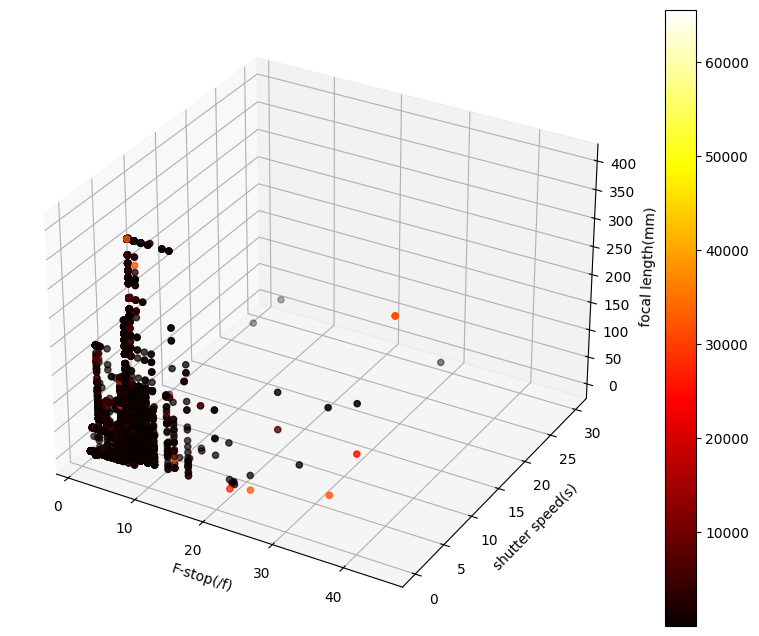

,shutter_speed(s),ISO,focal_length(mm),F_stop(/f)
K:\BaiduSyncdisk\Photos\Avatar.png,0.00625,100.0,6.3,4.0
K:\BaiduSyncdisk\Photos\117_PANA\P1170674.JPG,0.008,100.0,7.5,4.0
K:\BaiduSyncdisk\Photos\117_PANA\P1170675.JPG,0.0025,100.0,6.3,6.3
K:\BaiduSyncdisk\Photos\117_PANA\P1170676.JPG,0.025,100.0,7.5,3.2
K:\BaiduSyncdisk\Photos\117_PANA\P1170677.JPG,0.07692307692307693,200.0,6.3,2.8
...,...,...,...,...
K:\BaiduSyncdisk\Photos\漫展\IMG_3164.JPG,0.01,250.0,39.0,6.3
K:\BaiduSyncdisk\Photos\漫展\IMG_3166.JPG,0.0025,250.0,31.0,11.0
K:\BaiduSyncdisk\Photos\漫展\IMG_3167.JPG,0.016666666666666666,250.0,84.0,6.3
K:\BaiduSyncdisk\Photos\漫展\IMG_3171.JPG,0.002,100.0,57.0,9.0


In [15]:
# 以光圈值为x轴，快门速度为y轴，焦距为z轴，ISO值为颜色（值越大透明度越低）绘制3D散点图
# draw the 3D scatter plot of the relationship between F-stop, shutter speed, focal length and ISO

# remove the invalid data
images_df = images_df.dropna()

fig = plt.figure()
# size of the figure
fig.set_size_inches(10, 8)
ax = fig.add_subplot(111, projection="3d")
x = images_df["F_stop(/f)"]
y = images_df["shutter_speed(s)"]
z = images_df["focal_length(mm)"]
c = images_df["ISO"]
img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
ax.set_xlabel("F-stop(/f)")
ax.set_ylabel("shutter speed(s)")
ax.set_zlabel("focal length(mm)")
plt.show()
images_df